In [5]:
import numpy as np
import pandas as pd
#nltk自然语言处理工具包
import nltk
import re

'''
文本预处理：去掉个各种特殊符号和用处不大的停用词（对最终结果影响不大的词）
'''

corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!']
labels = ['weather', 'weather', 'animals', 'animals', 'weather', 'animals']
corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus,
                          'Category': labels})
print(corpus_df)

#加载停用词
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')


def normalize_document(doc):
    #字符串前缀 r 或 R 用于表示一个原始字符串（raw string）。原始字符串的特性是，不会对反斜杠（\）进行转义，使得字符串中的反斜杠被视为普通字符，而不是转义符
    #去掉特殊字符,re.sub函数会将满足指定正则的子字符串替换为给定的字符串
    #re.I表示匹配对大小写不敏感
    line_list = []
    for line in doc:
        line = re.sub(r' [^a-zA-Z0-9\s]', '', line, re.I)
        #转换成小写
        line = line.lower()
        #去除字符串开头和结尾的指定字符（默认为空格和换行符）
        line = line.strip()
        #分词
        tokens = wpt.tokenize(line)
        #去停用词
        filtered_tokens = [token for token in tokens if token not in stop_words]
        #重新组合成文章
        line = ' '.join(filtered_tokens)
        line_list.append(line)
    return np.array(line_list)


norm_corpus = normalize_document(corpus)
print('-' * 100)
print(norm_corpus)





                                            Document Category
0                     The sky is blue and beautiful.  weather
1                  Love this blue and beautiful sky!  weather
2       The quick brown fox jumps over the lazy dog.  animals
3   The brown fox is quick and the blue dog is lazy!  animals
4  The sky is very blue and the sky is very beaut...  weather
5        The dog is lazy but the brown fox is quick!  animals
----------------------------------------------------------------------------------------------------
['sky blue beautiful .' 'love blue beautiful sky !'
 'quick brown fox jumps lazy dog .' 'brown fox quick blue dog lazy !'
 'sky blue sky beautiful today' 'dog lazy brown fox quick !']


In [28]:
#开始进行特征提取
'''
词袋模型
CountVectorizer 用于将文本数据转为词频矩阵,每行文本一个向量
数字表示当前单词在该文本中出现的次数，向量维度等于当前文本不同单词的数量
参数详解：
    - min_df: 词语最小出现的文档数（过滤低频词）
    - max_df: 词语最多允许出现在多少比例的文档中（过滤高频词）
    - ngram_range（提取 N-gram 词组）
        ngram_range=(1,1): 默认，提取单个单词（Unigram）
        ngram_range=(2,2): 提取两个连续单词（Bigram）
        ngram_range=(1,2): 同时提取Unigram + Bigram
'''
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

cv = CountVectorizer(min_df=0., max_df=1., ngram_range=(1, 1))
cv.fit(norm_corpus)
print(cv.get_feature_names_out())
cv_matrix = cv.fit_transform(norm_corpus)
cv_matrix = cv_matrix.toarray()
print(cv_matrix)

df = pd.DataFrame(cv_matrix, columns=cv.get_feature_names_out())
print(df)


['beautiful' 'blue' 'brown' 'dog' 'fox' 'jumps' 'lazy' 'love' 'quick'
 'sky' 'today']
[[1 1 0 0 0 0 0 0 0 1 0]
 [1 1 0 0 0 0 0 1 0 1 0]
 [0 0 1 1 1 1 1 0 1 0 0]
 [0 1 1 1 1 0 1 0 1 0 0]
 [1 1 0 0 0 0 0 0 0 2 1]
 [0 0 1 1 1 0 1 0 1 0 0]]
   beautiful  blue  brown  dog  fox  jumps  lazy  love  quick  sky  today
0          1     1      0    0    0      0     0     0      0    1      0
1          1     1      0    0    0      0     0     1      0    1      0
2          0     0      1    1    1      1     1     0      1    0      0
3          0     1      1    1    1      0     1     0      1    0      0
4          1     1      0    0    0      0     0     0      0    2      1
5          0     0      1    1    1      0     1     0      1    0      0


In [38]:
'''
基于TF-IDF进行特征提取:不仅考虑词频，同时还会考虑次的重要程度
    TF-IDF(t)=TF(t,d)*IDF(t)
    TF(t,d):词频，词t在文档d中频率，单词t在文档d中出现的次数/文档d中的总单词数
    IDF(t):逆文档频率，log((总文档数/(包含单词t的文档数+1))
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(min_df=0., max_df=1., ngram_range=(1, 1))
print(norm_corpus)
tfidf_matrix = tfidf_vectorizer.fit_transform(norm_corpus)
tfidf_matrix = tfidf_matrix.toarray()

columns = tfidf_vectorizer.get_feature_names_out()
print(columns)
print(pd.DataFrame(np.round(tfidf_matrix, 2), columns=columns))


['sky blue beautiful .' 'love blue beautiful sky !'
 'quick brown fox jumps lazy dog .' 'brown fox quick blue dog lazy !'
 'sky blue sky beautiful today' 'dog lazy brown fox quick !']
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 28 stored elements and shape (6, 11)>
  Coords	Values
  (0, 9)	0.6047493735197427
  (0, 1)	0.5182242665631911
  (0, 0)	0.6047493735197427
  (1, 9)	0.455453973865905
  (1, 1)	0.39028945195301484
  (1, 0)	0.455453973865905
  (1, 7)	0.657873467373268
  (2, 8)	0.3756534976810389
  (2, 2)	0.3756534976810389
  (2, 4)	0.3756534976810389
  (2, 5)	0.5426069004353046
  (2, 6)	0.3756534976810389
  (2, 3)	0.3756534976810389
  (3, 1)	0.35785031358550456
  (3, 8)	0.4175986477628384
  (3, 2)	0.4175986477628384
  (3, 4)	0.4175986477628384
  (3, 6)	0.4175986477628384
  (3, 3)	0.4175986477628384
  (4, 9)	0.7151660734514929
  (4, 1)	0.3064214946831838
  (4, 0)	0.35758303672574643
  (4, 10)	0.5165053018373492
  (5, 8)	0.4472135954999579
  (5, 2)	0.4472135954999579

['人体中储存的热量由以下因素共同决定：(a)由于环境热应力（例如，温度高、湿度大、风力小、热辐射强），无法消除代谢过程中在体内产生的热量；(b)衣服形成热损失屏障；(c)来自环境的外部热量增益。\n', '在这种情况下，身体无法调节内部温度和消除热量增益，从而增加了热量消耗和中暑的风险。当身体试图给自己降温时，身体所承受的压力也会对心脏和肾脏造成压力。因此，极端高温会加剧慢性疾病（心血管、精神、呼吸道和糖尿病相关疾病）造成的健康风险，并导致急性肾损伤。\n', '极端高温天气会迅速（当天和随后几天）引起住院和死亡，这意味着在发布高温预警时也需要迅速采取干预措施。\n', '高温还可能扰乱和破坏基本的卫生服务，例如失去电力供应和运输。高温会降低工作生产力，增加事故风险。在极其炎热的天气里很难完成工作或学习，热浪可能导致学校和其他机构关闭。热浪也可能与危险的空气污染事件有关。\n', '高温对健康影响的规模和性质取决于高温事件的时间、强度和持续时间，以及当地人口、基础设施和机构对主要气候的适应水平。']
5
['人体', '中', '储存', '的', '热量', '由', '以下', '因素', '共同', '决定', '：', '(', 'a', ')', '由于', '环境', '热应力', '（', '例如', '，', '温度', '高', '、', '湿度', '大', '、', '风力', '小', '、', '热辐射', '强', '）', '，', '无法', '消除', '代谢', '过程', '中', '在', '体内', '产生', '的', '热量', '；', '(', 'b', ')', '衣服', '形成', '热', '损失', '屏障', '；', '(', 'c', ')', '来自', '环境', '的', '外部', '热量', '增益', '。', '\n', '在', '这种', '情况', '下', '，', '身体', '无法', '调节', '内部', '温度', '和', '消除', '热量', '增益', '，', '从而', '增加', '了', '热量', '消耗', '和', '中暑', '的', '风险', '。', '当', '身体', '试图', '给', '自己', '降温', '时', '，', 

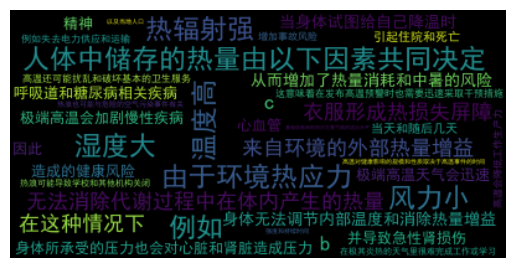

['高温', '热量', '增益', '热浪', '身体', '风险', '极端', '消除', '天气', '温度', '疾病', '健康', '热应力', '事件', '可能', '例如', '无法', '迅速', '环境', '空气污染']
{'后', '经', '$', '矣哉', '即', '我们', '“', '不然', '某个', '尽管', '哪些', '按', '始而', '所有', '乎', '也罢', '宁愿', '他们', '8', '赶', '嘿嘿', '要不然', '7', '总之', '所', '那般', '以故', '沿', '喽', '呢', '作为', '如何', '犹且', '腾', '哪', '呜', '她', '不尽', '为止', '有', '不但', '仍旧', '在', '俺', '但', '由', '这', '本人', '，', '哈哈', '怎么办', '这些', '乃至', '何以', '比及', '又及', '几', '既往', '以至于', '了', '或曰', '别人', '乘', '哎', '宁可', '若', '这么些', '让', '多', '纵', '以', '类如', '任', '就算', '可以', '此间', '某', '本着', '唉', '而言', '却', '哈', '给', '呸', '不怕', '也', '上下', '要', '果真', '随', '也好', '因了', '_', '自家', '不', '假使', '矣', '设若', '别', '同时', '比', '看', '另悉', '不惟', '即使', '今', '可见', '甚而', '莫若', '嗡嗡', '虽说', '加以', '遵循', '兼之', '呀', '就是了', '人家', '哎呀', '分别', '只怕', '各个', '是以', '某些', '来说', '什么', '其余', '个', '彼', '紧接着', '于', '比如', '何', '被', '用来', '一般', '一旦', '什么样', '朝', '要是', '即令', '对比', '哪天', '而已', '前后', '彼此', '因为', '不外乎', '打从', '一', '呜呼', '甚且', '如下', '再者说', '即或', '

In [12]:
import pandas as pd

#jieba 开源中文分词工具
import jieba
#生成词云的工具
#词云：将文本数据可视化的方式，其中每个单词的大小代表其在文本中出现的频率
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import jieba.analyse
import nltk


#文件数据读取
with open('./data.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
print(lines)
print(len(lines))


#定义文档分词方法
def termSplit(lines):
    result = []
    for line in lines:
        seg_list = jieba.lcut(line, cut_all=False)
        if len(seg_list) > 1 and seg_list != '\r\n':
            result=result+seg_list
    return result

termList=termSplit(lines)
print(termList)

# 生成词云
str=''.join(termList)
wordcloud = WordCloud(font_path="simhei.ttf").generate(str)

# 显示词云
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # 不显示坐标轴
plt.show()


#选取核心词,基于TF-IDF选择
tags=jieba.analyse.extract_tags(str)
print(tags)

#过滤停用词
#导入中文停用词数据
with open('./cn_stopwords.txt', 'r', encoding='utf-8') as ff:
    stopwords = set([line.strip() for line in ff])
print(stopwords)
termList_new=[term for term in termList if term not in stopwords]
print(len(termList),len(termList_new))

#重新选择核心词
tags_new=jieba.analyse.extract_tags(''.join(termList_new))
print(tags_new)
print(tags)









